In [38]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import tqdm

batch_size = 16
image_size = 32
channels = 3
shape = (batch_size, channels, image_size, image_size)

device = torch.device("cuda:0")

def show_grid(tensors, nrow=16, titles=[]):
    imgs = torch.cat([t.detach().cpu() for t in tensors])
    grid_img = torchvision.utils.make_grid(imgs, nrow=nrow)
    print(grid_img.shape)
    row_height = grid_img.shape[1] / len(tensors)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(grid_img.permute(1, 2, 0))
    ax.axis('off')
    for i, title in enumerate(titles):
        y_position = row_height / 2 + i * row_height
        ax.text(-10, y_position, title, color='white', fontsize=12, 
                ha='right', va='center', bbox=dict(facecolor='black', alpha=0.5))
    
    plt.show()

## args

In [2]:
import sys
sys.path.append('/mnt/hdd/home/home/asharshavin/other/Bayes/Project/for_elfat/ddib')

import argparse

from guided_diffusion.script_util import model_and_diffusion_defaults
from guided_diffusion import dist_util
from scripts.common import read_model_and_diffusion


def create_argparser():
    defaults = dict(
        task=0,  # 0 to 5 inclusive
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=64,
        microbatch=-1,  # -1 disables microbatches
        ema_rate="0.9999",  # comma-separated list of EMA values
        log_interval=10,
        save_interval=1000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=32,
    )
    defaults.update(model_and_diffusion_defaults())
    defaults.update({"image_size": 32})
    
    return defaults

args = argparse.Namespace(**create_argparser())

## model

Logging to /tmp/openai-2024-12-19-13-41-00-193410
Model path: /mnt/hdd/home/home/asharshavin/other/Bayes/Project/for_elfat/openai-2024-12-15-13-42-53-452013/model026000.pt


/mnt/hdd/home/home/asharshavin/other/Bayes/Project/for_elfat/ddib/guided_diffusion/dist_util.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(d

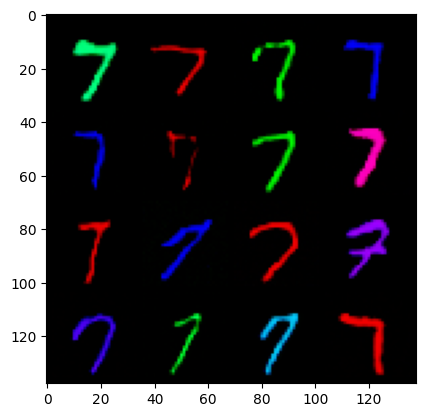

In [3]:
model_dir = "/mnt/hdd/home/home/asharshavin/other/Bayes/Project/for_elfat/openai-2024-12-15-13-42-53-452013/"
model, diffusion = read_model_and_diffusion(args, model_dir, synthetic=False)

sample = diffusion.ddim_sample_loop(
            model, shape,
            clip_denoised=True,
            device=dist_util.dev(),
        )

grid_img = torchvision.utils.make_grid(sample.detach().cpu(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

## Data

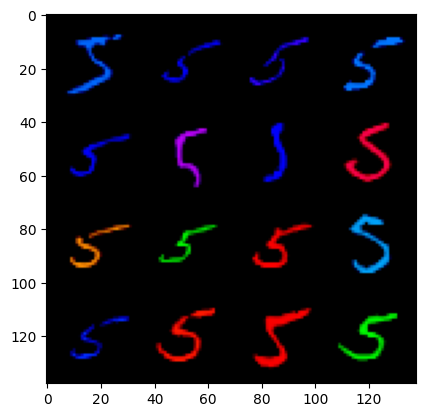

In [4]:
import torch.nn.functional as F

from scripts.colored_mnist_train import get_loader

# Load the dataset
data = get_loader(
    img_folder="/mnt/hdd/home/home/asharshavin/other/Bayes/Project/colored_mnist_5",
    batch_size=batch_size,
    training=False
)
batch, extra = list(data)[0]

batch = batch.to(device)

grid_img = torchvision.utils.make_grid(batch.detach().cpu(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

## Encode to noise

In [5]:
# First, use DDIM to encode to latents.
print("encoding the source images.")

start = time.time()
noise = diffusion.ddim_reverse_sample_loop(
    model,
    batch,
    clip_denoised=False,
    device=device,
)
end = time.time()

print(f"obtained latent representation for {batch.shape[0]} samples...")
print(f"encoding step takes {end - start} seconds")

encoding the source images.
obtained latent representation for 16 samples...
encoding step takes 19.934813499450684 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


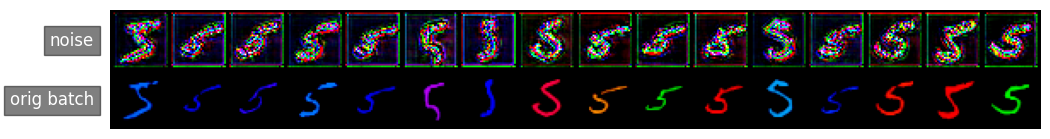

In [41]:
show_grid([noise, batch], nrow=16, titles=["noise", "orig batch"])

## Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


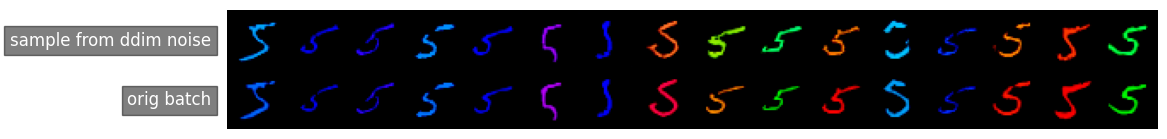

In [42]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise,
        clip_denoised=True,
        device=device,
        eta=0
    )

show_grid([sample, batch], nrow=16, titles=["sample from ddim noise", "orig batch"])

## Normalization noise

infinity and spatial-wise norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


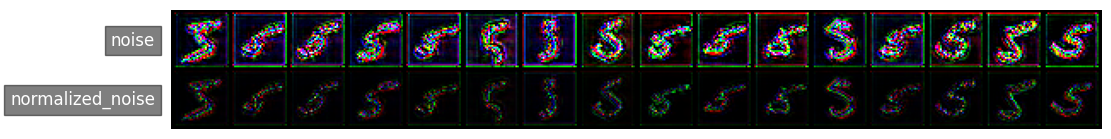

In [44]:
normalized_noise = noise / torch.norm(noise, dim=[2, 3], keepdim=True, p=np.inf)

show_grid([noise, normalized_noise], nrow=16, titles=['noise', 'normalized_noise'])

### some exp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 104, 546])


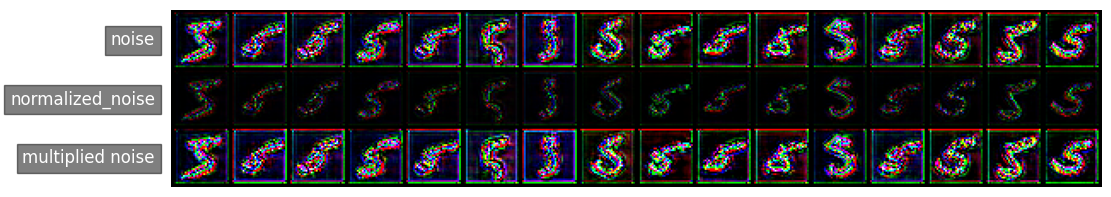

In [45]:
tau = 0.03
m = 10

coef = (1 + tau) ** m

new_noise = noise * coef
show_grid([noise, normalized_noise, new_noise], nrow=16, titles=['noise', 'normalized_noise', 'multiplied noise'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


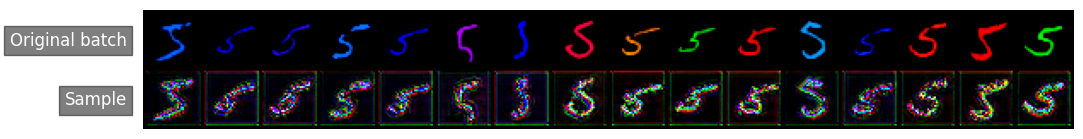

In [46]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=new_noise,
        clip_denoised=True,
        device=device,
        eta=0
    )

show_grid([batch, sample], nrow=16, titles=["Original batch", "Sample"])

## Add one noise step

In [ ]:
fixed_noise = torch.randn(shape, device=device)

In [48]:
coefs = [0.01, 0.1, 0.3, 0.7]

result_samples = []

after frobenius norm

100%|██████████| 4/4 [01:21<00:00, 20.36s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 172, 546])


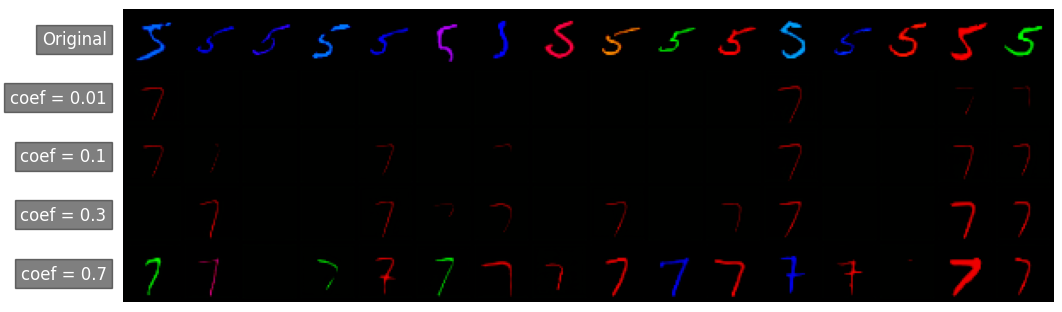

In [49]:
for c in tqdm.tqdm(coefs):
    sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=normalized_noise + c * fixed_noise,
        clip_denoised=True,
        device=device,
        eta=0
    )
    result_samples.append(sample)

show_grid([batch] + result_samples, nrow=16, titles=["Original"] + [f"coef = {c}" for c in coefs])

after infiity and spatial-wise norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


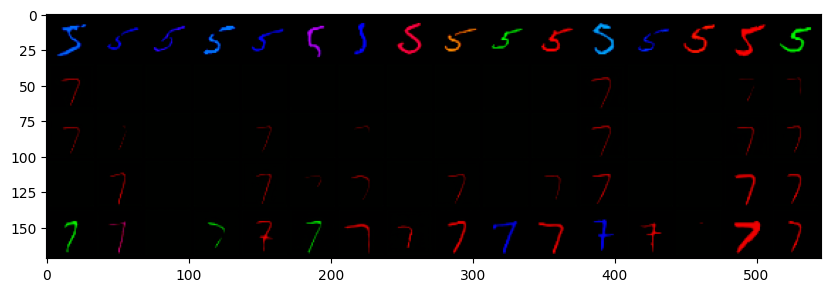

In [22]:
for c in tqdm.tqdm(coefs):
    sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=normalized_noise + c * fixed_noise,
        clip_denoised=True,
        device=device,
        eta=0
    )
    result_samples.append(sample)

show_grid([batch] + result_samples, nrow=16)

original noise

100%|██████████| 4/4 [01:19<00:00, 19.79s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 172, 546])


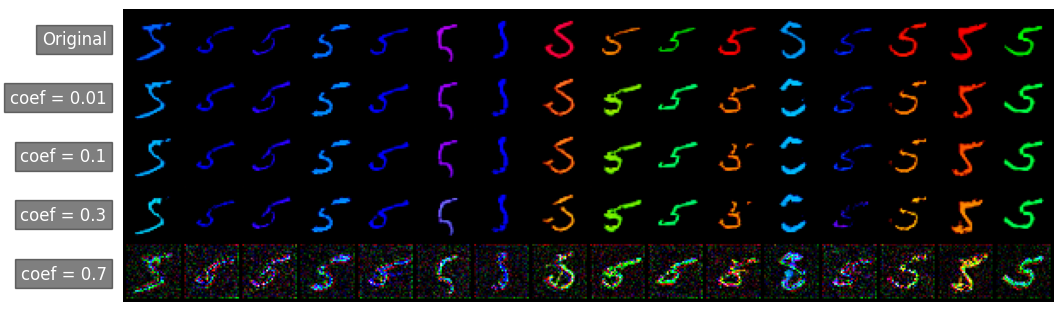

In [50]:
result_samples_dflt_noise = []

for c in tqdm.tqdm(coefs):
    sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise + c * fixed_noise,
        clip_denoised=True,
        device=device,
        eta=0
    )
    result_samples_dflt_noise.append(sample)

show_grid([batch] + result_samples_dflt_noise, nrow=16, titles=["Original"] + [f"coef = {c}" for c in coefs])

blend

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 104, 546])


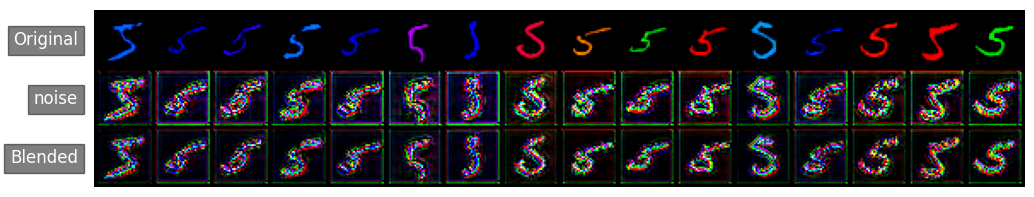

In [52]:
blended_latent = (batch + noise) / 2
show_grid([batch, noise, blended_latent], nrow=16, titles=["Original", "noise", "Blended"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


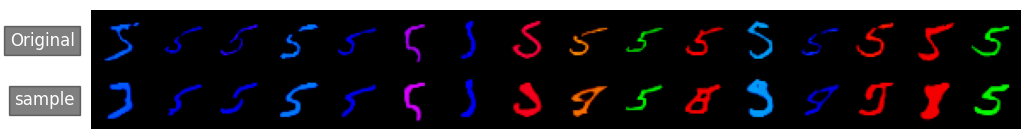

In [54]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=blended_latent,
        clip_denoised=True,
        device=device,
    )

show_grid([batch, sample], nrow=16, titles=["Original", "sample"])

100%|██████████| 5/5 [01:42<00:00, 20.56s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 206, 546])


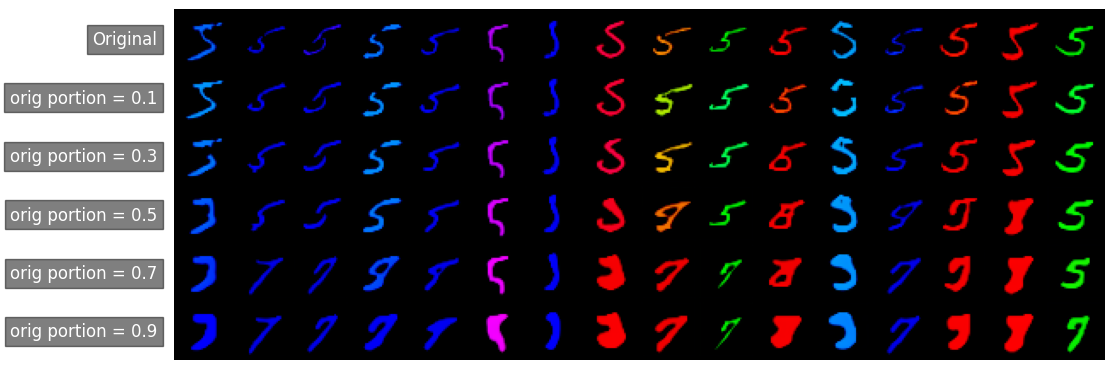

In [55]:
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]

blended_results = []

for p in tqdm.tqdm(proportions):
    blended_latent = p * batch + (1 - p) * noise
    sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=blended_latent,
        clip_denoised=True,
        device=device,
    )
    blended_results.append(sample)

show_grid([batch] + blended_results, nrow=16, titles=["Original"] + [f"orig portion = {p}" for p in proportions])

blend - checkerboard

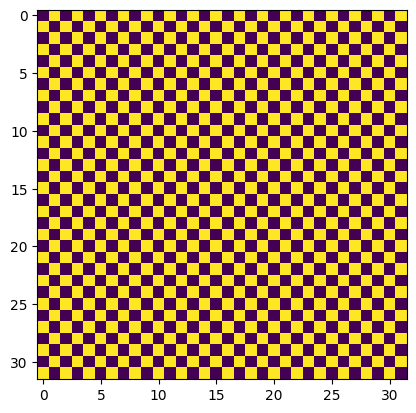

In [67]:
cb = torch.ones(32, 32)
for i in range(32):
    for j in range(32):
        cb[i, j] = int((i + j) % 2)

plt.imshow(cb)

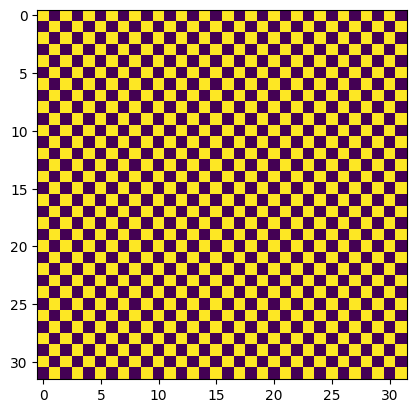

In [68]:
plt.imshow(1 - cb)

In [69]:
cb = cb[None, None, :]
cb.shape

torch.Size([1, 1, 32, 32])

In [71]:
blended_cb_latent = batch * cb.to(device) + noise * (1 - cb).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 104, 546])


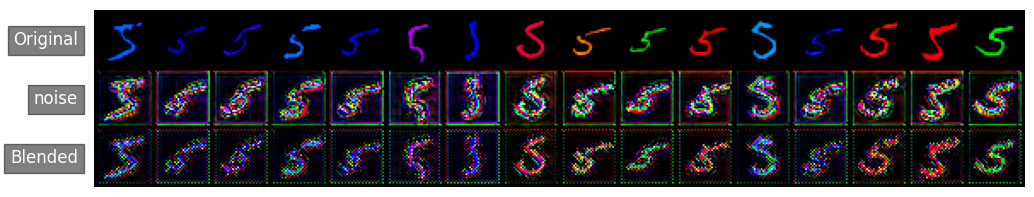

In [72]:
show_grid([batch, noise, blended_cb_latent], nrow=16, titles=["Original", "noise", "Blended"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


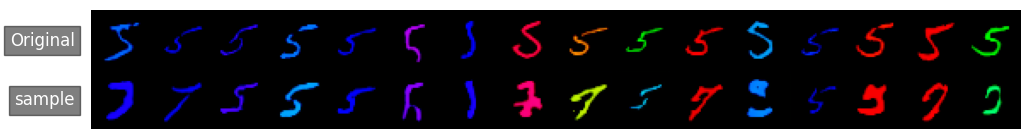

In [73]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=blended_cb_latent,
        clip_denoised=True,
        device=device,
    )

show_grid([batch, sample], nrow=16, titles=["Original", "sample"])

blend with stochastic noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 104, 546])


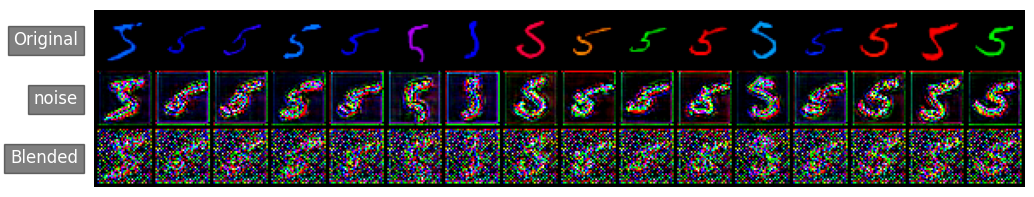

In [74]:
fixed_noise = torch.randn(1, 3, 32, 32, device=device)
blended_cb_latent_2 = fixed_noise * cb.to(device) + noise * (1 - cb).to(device)
show_grid([batch, noise, blended_cb_latent_2], nrow=16, titles=["Original", "noise", "Blended"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


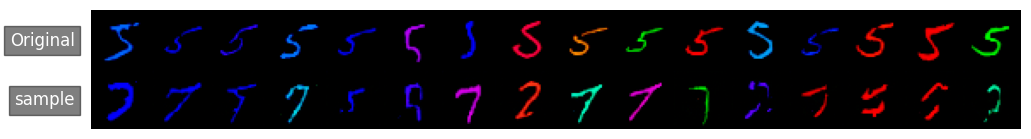

In [75]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=blended_cb_latent_2,
        clip_denoised=True,
        device=device,
    )

show_grid([batch, sample], nrow=16, titles=["Original", "sample"])

Small local rotation

In [93]:
def rotate_2x2_blocks_clockwise(matrix):
    """
    Splits the input matrix into 2x2 blocks and rotates each block clockwise.

    Args:
        matrix (numpy.ndarray): Input 2D matrix of size N x N (divisible by 2).

    Returns:
        numpy.ndarray: Matrix after applying clockwise rotation to all 2x2 blocks.
    """
    # Validate input matrix dimensions
    _, _, rows, cols = matrix.shape
    if rows % 2 != 0 or cols % 2 != 0:
        raise ValueError("Matrix dimensions must be divisible by 2.")

    # Copy the matrix to avoid modifying the original
    output_matrix = matrix.clone()

    # Iterate over all 2x2 blocks
    for ba in range(matrix.shape[0]):
        for ch in range(3):
            for i in range(0, rows, 2):
                for j in range(0, cols, 2):
                    # Extract the 2x2 block
                    a = matrix[ba, ch, i, j]
                    b = matrix[ba, ch, i, j+1]
                    c = matrix[ba, ch, i+1, j]
                    d = matrix[ba, ch, i+1, j+1]

                    # Apply the clockwise rotation and assign back
                    output_matrix[ba, ch, i, j]   = c  # Top-left
                    output_matrix[ba, ch, i, j+1] = a  # Top-right
                    output_matrix[ba, ch, i+1, j] = d  # Bottom-left
                    output_matrix[ba, ch, i+1, j+1] = b  # Bottom-right

    return output_matrix

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


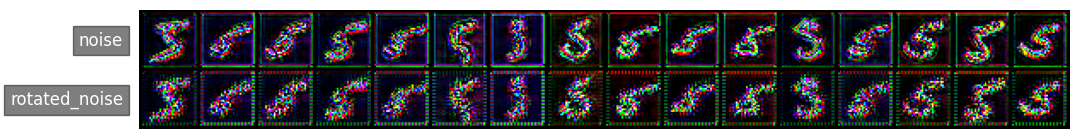

In [94]:
rotated_noise = rotate_2x2_blocks_clockwise(noise)

show_grid([noise, rotated_noise], nrow=16, titles=["noise", "rotated_noise"])

torch.Size([3, 70, 546])


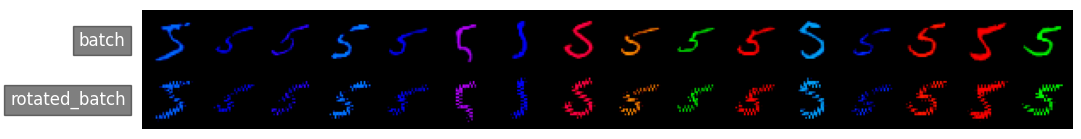

In [96]:
rotated_batch = rotate_2x2_blocks_clockwise(batch)

show_grid([batch, rotated_batch], nrow=16, titles=["batch", "rotated_batch"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 70, 546])


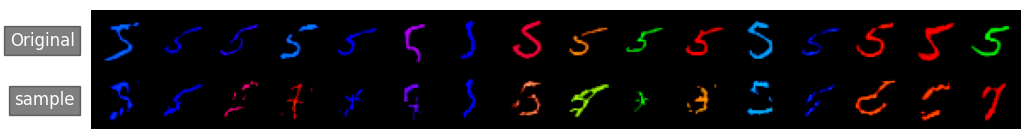

In [95]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=rotated_noise,
        clip_denoised=True,
        device=device,
    )

show_grid([batch, sample], nrow=16, titles=["Original", "sample"])